In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

# basic libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import re
import string
from collections import Counter
import time

#visulaization modules
import matplotlib.pyplot as plt
import missingno as msno
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode


#Common model helpers
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder,)
from sklearn.compose import ColumnTransformer


from sklearn.metrics import (accuracy_score,
                             auc,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report,
                             plot_confusion_matrix,
                             r2_score,
                             get_scorer_names,
                             roc_curve)

from sklearn.model_selection import (GridSearchCV,
                                     RandomizedSearchCV,
                                     StratifiedKFold,
                                     cross_val_score,
                                     train_test_split)


# dimensionality reduction
from sklearn.decomposition import PCA
#from umap import UMAP
import pylab as pl

# imbalance dataset handling
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from imblearn.datasets import make_imbalance
from imblearn.under_sampling import (RandomUnderSampler,
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     EditedNearestNeighbours,
                                     NearMiss)


from imblearn.over_sampling import (SMOTE,
                                    SMOTENC,
                                    ADASYN,
                                    RandomOverSampler)




# model algorithams
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

%matplotlib inline

In [2]:
data = pd.read_csv('../data/full.csv')
data.drop(['id', 'index'], inplace=True, axis=1)

In [3]:
target = data['stroke']
cat_features = ['work_type']
num_features = ['age','avg_glucose_level','bmi']
other_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']

In [4]:
standard = StandardScaler()
encode = OneHotEncoder()
feat_en = encode.fit_transform(data[cat_features]).toarray()
feat_st = standard.fit_transform(data[num_features])
features = np.concatenate((feat_en, feat_st, data[other_features]), axis=1)

features_train,features_test,target_train,target_test=train_test_split(features, target ,test_size=0.2,stratify=target,random_state=100)

In [17]:
re_samplers = [SMOTE(), ADASYN(), RandomOverSampler(), RandomUnderSampler(), ClusterCentroids(), TomekLinks(), NeighbourhoodCleaningRule(), EditedNearestNeighbours(),NearMiss()]

In [18]:
resampled_data = [['OriginalData', features_train, target_train]]

for el in re_samplers:
    x_train, y_train = el.fit_resample(features_train, target_train)
    resampled_data.append([str(el), x_train, y_train])


In [19]:
def resampling():
    fitting_results = pd.DataFrame()

    for line in resampled_data:
        models = [[SVC(), 'SVC'],
                  [GradientBoostingClassifier(), 'GradientBoostingClassifier'],
                  [LogisticRegression(), 'LogisticRegression'],
                  [LGBMClassifier(), 'LGBMClassifier']]
        fitting_results = pd.concat([fitting_results, fitting(line[1], line[2], line[0], models)], axis=0)

    return fitting_results

def fitting(x, y, resemp, models):
    p = pd.DataFrame()

    for model in models:
        model[0].fit(x, y)
        prediction = model[0].predict(features_test)

        dict = {
        'resempler':[resemp],
        'classifier_name':[model[1]],
        'f1_score': [f1_score(target_test, prediction)],
        'accuracy_score':[accuracy_score(target_test, prediction)],
        'precision_score': [precision_score(target_test, prediction)],
        'recall_score':[recall_score(target_test, prediction)],
        'roc_auc_score':[roc_auc_score(target_test, prediction)],
        'confusion_matrix':[confusion_matrix(target_test,prediction)]
        }

        p = pd.concat([pd.DataFrame(dict), p], axis=0)
    return p

In [20]:
res = resampling()
res.sort_values(['roc_auc_score'], ascending=False)

,resempler,classifier_name,f1_score,accuracy_score,precision_score,recall_score,roc_auc_score,confusion_matrix
0,NeighbourhoodCleaningRule(),GradientBoostingClassifier,0.257143,0.947047,0.321429,0.214286,0.597036,"[[921, 19], [33, 9]]"
0,SMOTE(),GradientBoostingClassifier,0.203046,0.840122,0.129032,0.476190,0.666287,"[[805, 135], [22, 20]]"
0,RandomOverSampler(),GradientBoostingClassifier,0.202166,0.774949,0.119149,0.666667,0.723227,"[[733, 207], [14, 28]]"
0,RandomUnderSampler(),GradientBoostingClassifier,0.191257,0.698574,0.108025,0.833333,0.762943,"[[651, 289], [7, 35]]"
0,ClusterCentroids(),SVC,0.188889,0.702648,0.106918,0.809524,0.753698,"[[656, 284], [8, 34]]"
0,RandomOverSampler(),LogisticRegression,0.188034,0.709776,0.106796,0.785714,0.746049,"[[664, 276], [9, 33]]"
0,ClusterCentroids(),LogisticRegression,0.187683,0.717923,0.107023,0.761905,0.738931,"[[673, 267], [10, 32]]"
0,RandomUnderSampler(),LGBMClassifier,0.187500,0.708758,0.106452,0.785714,0.745517,"[[663, 277], [9, 33]]"
0,SMOTE(),LogisticRegression,0.184438,0.711813,0.104918,0.761905,0.735740,"[[667, 273], [10, 32]]"
0,ADASYN(),GradientBoostingClassifier,0.182692,0.826884,0.114458,0.452381,0.647999,"[[793, 147], [23, 19]]"


In [21]:
def roc(model, resempler, name):
    x_train, y_train = resempler.fit_resample(features_train, target_train)
    model.fit(x_train, y_train)
    y_prob = model.predict_proba(features_test)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate,true_positive_rate, label = f'{name} AUC = %0.3f' % roc_auc)

    #return false_positive_rate, true_positive_rate, roc_auc

Text(0.5, 0, 'False Positive Rate')

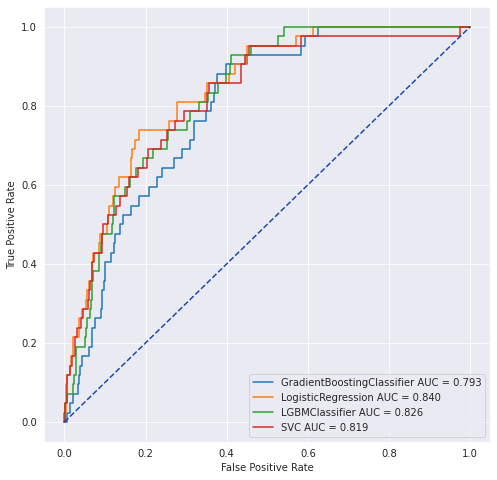

In [26]:
plt.figure(figsize = (8, 8))

DCTclassifier = DecisionTreeClassifier(max_depth=3, random_state=2022)
#roc(XGBMclassifier, SMOTE(), 'XGBMclassifier')

roc(GradientBoostingClassifier(), RandomUnderSampler(), 'GradientBoostingClassifier')
roc(LogisticRegression(), RandomOverSampler(), 'LogisticRegression')
roc(LGBMClassifier(), RandomUnderSampler(), 'LGBMClassifier')
roc(SVC(probability=True), ClusterCentroids(), 'SVC')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [8]:
gradient_params = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750], 'max_depth':[2,3,4,5,6,7]}
svc_params = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
logistic_param = {'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
lgbc_param ={'num_leaves': sp_randint(6, 50),
             'min_child_samples': sp_randint(100, 500),
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8),
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


In [43]:
best_models = [[GradientBoostingClassifier(), gradient_params],
               [LogisticRegression(), logistic_param],
               [LGBMClassifier(), lgbc_param],
               [SVC(probability=True), svc_params],

               [LogisticRegression(), logistic_param]]
best_resamplers = [RandomUnderSampler(), RandomOverSampler(), RandomUnderSampler(), ClusterCentroids()]
searches =[]

for i in range(4):
    X_resample, y_resample = best_resamplers[i].fit_resample(features_train, target_train)
    model = best_models[i][0]

    rand = RandomizedSearchCV(estimator=model, param_distributions=best_models[i][1], scoring = 'roc_auc',cv = 10)
    rand.fit(X_resample, y_resample)
    best_accuracy = rand.best_score_
    best_param = rand.best_params_
    searches.append(rand)
    print(' {}: \n Best Accuracy: {:.2f} %'.format(model,best_accuracy*100))
    print('')
    print('-'*25)
    print('')


 GradientBoostingClassifier(): 
 Best Accuracy: 84.76 %

-------------------------

 LogisticRegression(): 
 Best Accuracy: 85.34 %

-------------------------

 LGBMClassifier(): 
 Best Accuracy: 50.00 %

-------------------------

 SVC(probability=True): 
 Best Accuracy: 82.00 %

-------------------------



In [44]:

prediction = searches[1].predict(features_test)

dict = {
        'f1_score': [f1_score(target_test, prediction)],
        'accuracy_score':[accuracy_score(target_test, prediction)],
        'precision_score': [precision_score(target_test, prediction)],
        'recall_score':[recall_score(target_test, prediction)],
        'roc_auc_score':[roc_auc_score(target_test, prediction)],
        'confusion_matrix':[confusion_matrix(target_test,prediction)]
        }
dict

{'f1_score': [0.19428571428571428],
 'accuracy_score': [0.7128309572301426],
 'precision_score': [0.11038961038961038],
 'recall_score': [0.8095238095238095],
 'roc_auc_score': [0.7590172239108409],
 'confusion_matrix': [array([[666, 274],
         [  8,  34]])]}

In [6]:
def roc2(model, name):
    y_prob = model.predict_proba(features_test)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate,true_positive_rate, label = f'{name} AUC = %0.3f' % roc_auc)
    prediction = searches[0].predict(features_test)

    dict = {
        'f1_score': [f1_score(target_test, prediction)],
        'accuracy_score':[accuracy_score(target_test, prediction)],
        'precision_score': [precision_score(target_test, prediction)],
        'recall_score':[recall_score(target_test, prediction)],
        'roc_auc_score':[roc_auc_score(target_test, prediction)],
        'roc_auc':[roc_auc],
        'confusion_matrix':[confusion_matrix(target_test,prediction)]
        }
    print(dict)

    #return false_positive_rate, true_positive_rate, roc_auc

{'f1_score': [0.19428571428571428], 'accuracy_score': [0.7128309572301426], 'precision_score': [0.11038961038961038], 'recall_score': [0.8095238095238095], 'roc_auc_score': [0.7590172239108409], 'roc_auc': [0.839564336372847], 'confusion_matrix': [array([[666, 274],
       [  8,  34]])]}
{'f1_score': [0.19428571428571428], 'accuracy_score': [0.7128309572301426], 'precision_score': [0.11038961038961038], 'recall_score': [0.8095238095238095], 'roc_auc_score': [0.7590172239108409], 'roc_auc': [0.8386018237082067], 'confusion_matrix': [array([[666, 274],
       [  8,  34]])]}
{'f1_score': [0.19428571428571428], 'accuracy_score': [0.7128309572301426], 'precision_score': [0.11038961038961038], 'recall_score': [0.8095238095238095], 'roc_auc_score': [0.7590172239108409], 'roc_auc': [0.8378926038500507], 'confusion_matrix': [array([[666, 274],
       [  8,  34]])]}


Text(0.5, 0, 'False Positive Rate')

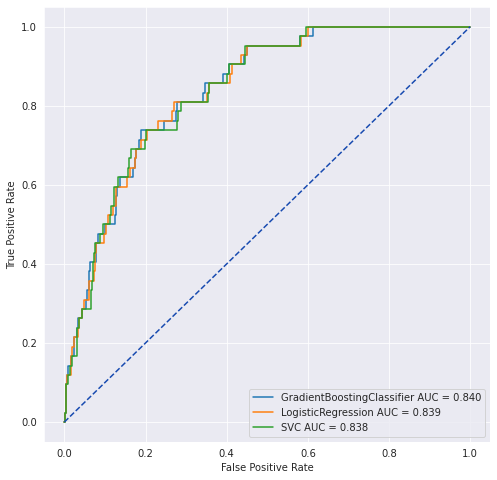

In [13]:
plt.figure(figsize = (8, 8))

DCTclassifier = DecisionTreeClassifier(max_depth=3, random_state=2022)
#roc(XGBMclassifier, SMOTE(), 'XGBMclassifier')
searches[3].probability=True

roc2(searches[0], 'GradientBoostingClassifier')
roc2(searches[1], 'LogisticRegression')
roc2(searches[3], 'SVC')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [9]:
searches = []

for i in range(4):
    X_resample, y_resample = RandomOverSampler().fit_resample(features_train, target_train)
    model = LogisticRegression()

    rand = RandomizedSearchCV(estimator=model, param_distributions=logistic_param, scoring = 'roc_auc',cv = 10)
    rand.fit(X_resample, y_resample)
    best_accuracy = rand.best_score_
    best_param = rand.best_params_
    searches.append(rand)
    print(' {}: \n Best Accuracy: {:.2f} %'.format(model,best_accuracy*100))
    print('')
    print('-'*25)
    print('')


 LogisticRegression(): 
 Best Accuracy: 85.38 %

-------------------------

 LogisticRegression(): 
 Best Accuracy: 85.62 %

-------------------------

 LogisticRegression(): 
 Best Accuracy: 85.43 %

-------------------------

 LogisticRegression(): 
 Best Accuracy: 85.16 %

-------------------------



In [16]:
prediction = searches[1].predict(features_test)

dict = {
        'f1_score': [f1_score(target_test, prediction)],
        'accuracy_score':[accuracy_score(target_test, prediction)],
        'precision_score': [precision_score(target_test, prediction)],
        'recall_score':[recall_score(target_test, prediction)],
        'roc_auc_score':[roc_auc_score(target_test, prediction)],
        #'roc_auc':[auc(target_test, prediction)],
        'confusion_matrix':[confusion_matrix(target_test,prediction)]
        }
dict

{'f1_score': [0.192090395480226],
 'accuracy_score': [0.7087576374745418],
 'precision_score': [0.10897435897435898],
 'recall_score': [0.8095238095238095],
 'roc_auc_score': [0.7568895643363729],
 'confusion_matrix': [array([[662, 278],
         [  8,  34]])]}

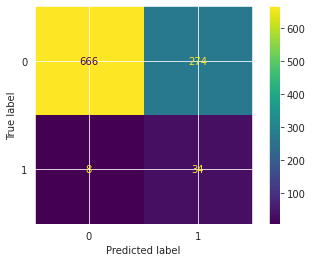

In [25]:
plot_confusion_matrix(searches[0], features_test, target_test)  
plt.show()